# Imports

In [ ]:
import pandas as pd
import numpy as np
import os

import librosa
import IPython.display as ipd
import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# EDA

In [7]:
samplename = 'Sound_Dataset/gun_shot.wav'

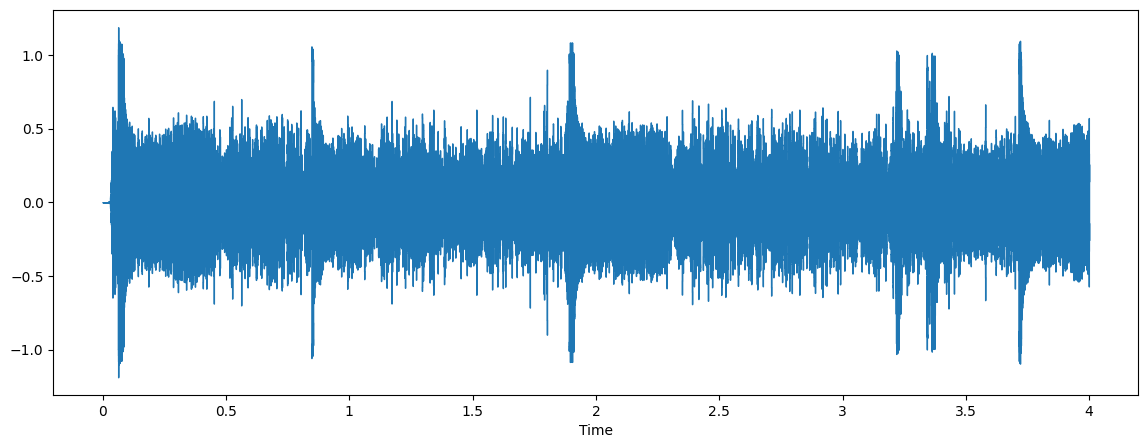

In [8]:
# Sample Sound -- gunshot -- EDA

plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(samplename)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(samplename)

In [9]:
sample_rate

22050

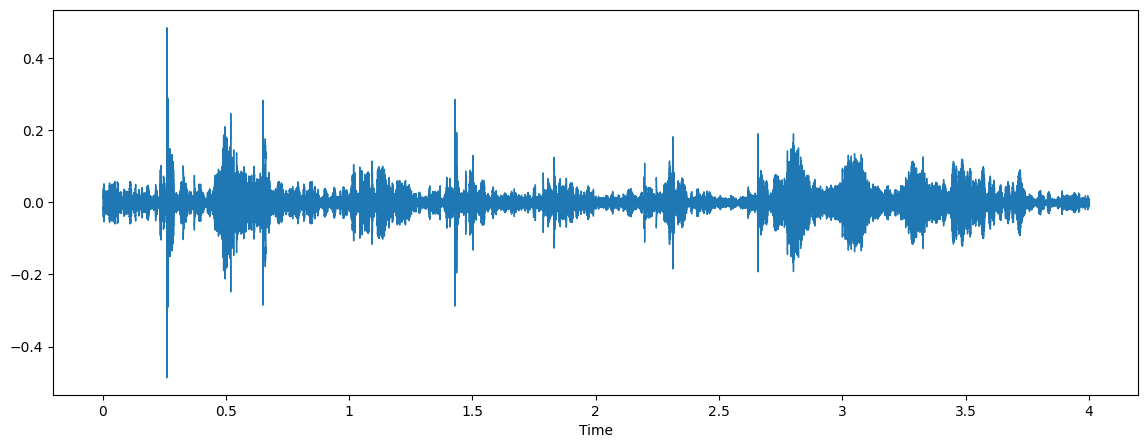

In [10]:
### Random_Sound_Selection
samplename='Sound_Dataset/fold1/203440-3-0-1.wav'
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(samplename)
librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(samplename)


In [11]:
sample_rate

22050

In [12]:
# we will compare channel of librosa and scipy on this audio
audio_file_path='Sound_Dataset/fold1/203440-3-0-1.wav'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)   

In [13]:
print(librosa_audio_data)

[ 3.8333135e-03 -8.3394628e-04 -4.5281844e-03 ... -1.9462581e-03
  7.8653946e-05  1.0936691e-03]


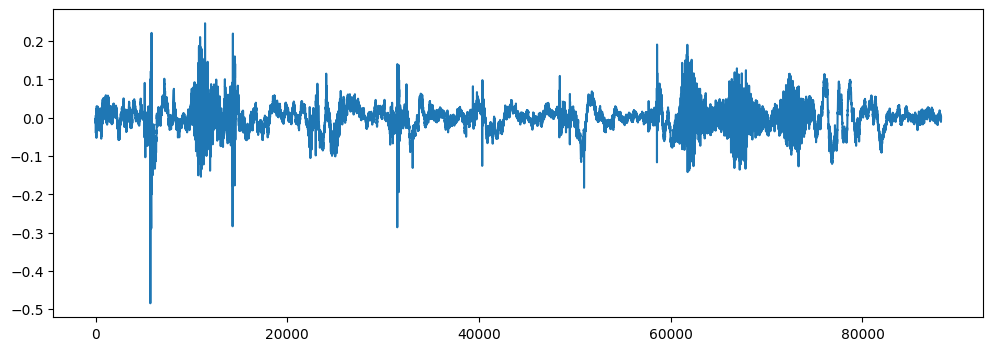

In [ ]:
### Plot of librosa audio data
# Original audio with 1 channel 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

In [16]:
## OBSERVATION -- WE ARE GETTING MONO ONLY ONE CHANNEL BECAUSE WE ARE USING librosa AND IT CONVERTS THE AUDIO TO MONO CHANNEL

## Experimenting with alternate Sci-Pi Library

In [17]:
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio=wav.read(samplename)

In [18]:
wave_sample_rate

44100

In [19]:
wave_audio.shape

(176400, 2)

In [20]:
wave_audio

array([[-1049,  1525],
       [-1175,  1291],
       [-1378,  1149],
       ...,
       [  732,  -687],
       [  745,  -677],
       [  724,  -660]], dtype=int16)

In [21]:
wave_sample_rate, wave_audio = wav.read(audio_file_path) 
wave_audio

array([[-1049,  1525],
       [-1175,  1291],
       [-1378,  1149],
       ...,
       [  732,  -687],
       [  745,  -677],
       [  724,  -660]], dtype=int16)

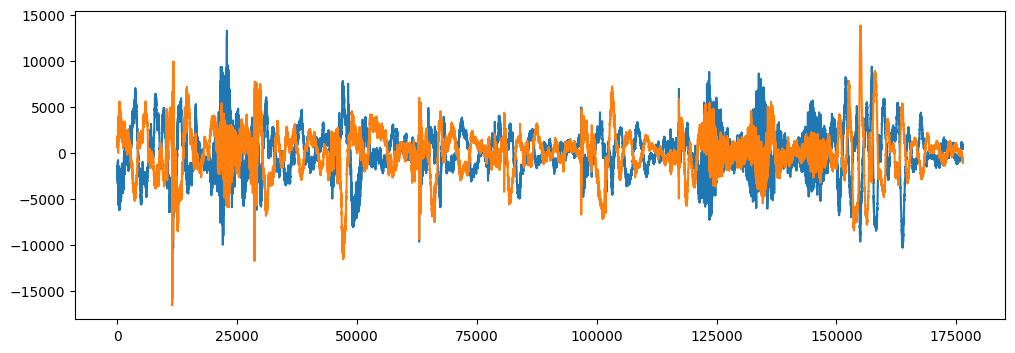

In [22]:
# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

### WE WILL BE USING LIBROSA NOW

In [23]:
# Reverting to librosa
data

array([ 3.8333135e-03, -8.3394628e-04, -4.5281844e-03, ...,
       -1.9462581e-03,  7.8653946e-05,  1.0936691e-03], dtype=float32)

In [31]:
# Load metadata
audio_dataset_path = 'Sound_Dataset/'
metadata = pd.read_csv('Sound_Dataset/soundmaps.csv')
metadata.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [26]:
### Check whether the dataset is imbalanced AND ALSO CHECKING THE CLASS DISTRIBUTION
metadata['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

In [27]:
# OBSERVATION - Looks that the dataset is balanced

# FEATURE EXTRACTION AND DATA PREPROCESSING

In [28]:
# Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [29]:
# 1. Data Loading and Feature Extraction
def features_extractor(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        
        # Extract multiple features instead of just MFCC
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sample_rate)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=sample_rate)
        
        # Combine all features
        features = np.vstack([mfccs, chroma, mel, contrast, tonnetz])
        features_scaled = np.mean(features.T, axis=0)
        
        return features_scaled
    except Exception as e:
        print(f"Error encountered while parsing {file_name}: {e}")
        return None

In [32]:
# Extract features with error handling
extracted_features = []
for index_num, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path), 
                           'fold'+str(row["fold"])+'/', 
                           str(row["slice_file_name"]))
    final_class_labels = row["class"]
    data = features_extractor(file_name)
    if data is not None:
        extracted_features.append([data, final_class_labels])

0it [00:00, ?it/s]/opt/anaconda3/envs/normal/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=876
  warnings.warn(
/opt/anaconda3/envs/normal/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=438
  warnings.warn(
/opt/anaconda3/envs/normal/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=219
  warnings.warn(
/opt/anaconda3/envs/normal/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=110
  warnings.warn(
9it [00:00, 12.75it/s]/opt/anaconda3/envs/normal/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=894
  warnings.warn(
/opt/anaconda3/envs/normal/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=

In [33]:
# Convert to DataFrame
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
extracted_features_df.head(10)

,feature,class
0,"[-217.35525594438826, 70.2233829498291, -130.3...",dog_bark
1,"[-424.09816869834947, 109.34076284948802, -52....",children_playing
2,"[-458.79112834599664, 121.38419752176097, -46....",children_playing
3,"[-413.8998185527118, 101.6637197505532, -35.42...",children_playing
4,"[-446.60353838088196, 113.6854161609804, -52.4...",children_playing
5,"[-446.82549784224847, 117.01193307865562, -33....",children_playing
6,"[-476.60765296186327, 119.41842157441067, -28....",children_playing
7,"[-464.0825802136019, 116.31008712680354, -28.8...",children_playing
8,"[-471.3208041328915, 125.25888308486498, -36.9...",children_playing
9,"[-196.82199260166712, 113.99312128339496, -13....",car_horn


In [38]:
#Data Preprocessing
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

In [39]:
X.shape

(8732, 193)

In [40]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [41]:
# Label Encoding
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [42]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [43]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
X_train

array([[-8.80240972e+01,  1.15684671e+02, -9.68509362e+01, ...,
         2.00803209e-02,  1.68352979e-02, -1.02836959e-02],
       [-1.62190351e+02,  1.33891235e+02, -2.55662389e+01, ...,
        -4.16197324e-02, -8.31302778e-03, -1.77124611e-02],
       [-2.62374594e+02,  1.76690993e+02, -1.12590793e+02, ...,
        -1.69528000e-02, -1.44647944e-03,  1.82859249e-02],
       ...,
       [-2.91092551e+02,  2.33220094e+02, -4.70138954e+00, ...,
         4.47144835e-03,  1.41966742e-02, -3.26675699e-02],
       [-2.00923102e+02,  9.21831069e+01, -7.96089752e+01, ...,
         4.50284709e-02, -1.77550441e-02, -1.31666157e-02],
       [-2.70923011e+02,  1.34519645e+02, -7.87687177e+00, ...,
        -1.64071218e-02, -9.11452136e-03,  1.38406488e-02]])

In [45]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [47]:
X_train.shape

(6985, 193)

In [48]:
X_test.shape

(1747, 193)

In [49]:
y_train.shape

(6985, 10)

In [50]:
y_test.shape

(1747, 10)

# MODEL TRAINING

In [51]:
#Model Architecture Improvements
num_labels = y.shape[1]

In [52]:
num_labels

10

In [53]:
model = Sequential()

In [54]:
# Input layer with batch normalization
model.add(Dense(256, input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Hidden layers
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

/opt/anaconda3/envs/normal/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
# Compile with adjusted learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'], 
              optimizer=optimizer)

In [58]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,242 (1.22 MB)

 Trainable params: 317,194 (1.21 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [56]:
# Callbacks
checkpointer = ModelCheckpoint(filepath='saved_models/best_audio_classification_final.keras', 
                             verbose=1, 
                             save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20, 
                              verbose=1, 
                              restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                             factor=0.2,
                             patience=5, 
                             min_lr=0.00001, 
                             verbose=1)


In [57]:
num_epochs = 200
num_batch_size = 64

In [59]:
# Training
history = model.fit(X_train, y_train, 
                   batch_size=num_batch_size, 
                   epochs=num_epochs, 
                   validation_data=(X_test, y_test), 
                   callbacks=[checkpointer, early_stopping, reduce_lr], 
                   verbose=1)

Epoch 1/200
105/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1239 - loss: 2.8097
Epoch 1: val_loss improved from inf to 2.07039, saving model to saved_models/best_audio_classification_final.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1249 - loss: 2.8029 - val_accuracy: 0.2816 - val_loss: 2.0704 - learning_rate: 1.0000e-04
Epoch 2/200
100/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2202 - loss: 2.3963
Epoch 2: val_loss improved from 2.07039 to 1.85714, saving model to saved_models/best_audio_classification_final.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2211 - loss: 2.3926 - val_accuracy: 0.3892 - val_loss: 1.8571 - learning_rate: 1.0000e-04
Epoch 3/200
 96/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2470 - loss: 2.2285
Epoch 3: val_loss improved from 1.85714 to 1.74384, saving model to saved_models/best_audio_classification_final.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2481 - loss: 2.2238 - val_accuracy: 0.411

In [62]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy[1]*100:.2f}%")

Test Accuracy: 89.75%


In [63]:
#Prediction
def predict_audio_class(file_path):
    features = features_extractor(file_path)
    if features is not None:
        features = features.reshape(1, -1)
        prediction = model.predict(features)
        predicted_label = np.argmax(prediction, axis=1)
        prediction_class = labelencoder.inverse_transform(predicted_label)
        return prediction_class[0]
    return "Error in processing file"

In [67]:
# Example usage
filename = "Sound_Dataset/1.wav"
predicted_class = predict_audio_class(filename)
print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted class: dog_bark
